<a href="https://colab.research.google.com/github/bthu207/pp2024/blob/main/%5Bofficial%5D_real_fake_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.

1.1 mount drive và lập path

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')


In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# --- DEFINITION OF CORE VARIABLES ---
# New CSV structure: ID, num_ID, Label (Status)
IMAGE_BRANDS = ['Apple', 'Samsung', 'Microsoft', 'LG', 'Google', '7up', 'KFC']
ALLOWED_BRANDS = IMAGE_BRANDS

# --- FINAL PATH ---
BASE_PATH = Path('/content/drive/MyDrive/[DS-B3] intro to DL/Dataset/')
DATASET_DIR = BASE_PATH / 'Processed_Img'
CSV_DIR = BASE_PATH / 'Mapping_CSV'

CSV_FILES = {
    'Apple': CSV_DIR / 'Apple.csv', 'Samsung': CSV_DIR / 'Samsung.csv',
    'Microsoft': CSV_DIR / 'Microsoft.csv', 'LG': CSV_DIR / 'LG.csv',
    'Google': CSV_DIR / 'Google.csv', '7up': CSV_DIR / '7up.csv',
    'KFC': CSV_DIR / 'KFC.csv', 'all_brand': CSV_DIR / 'all_brand.csv'
}



# ID Normalization Function
def normalize_file_id(file_id_str):
    if isinstance(file_id_str, str):
        parts = file_id_str.split('_')
        if len(parts) == 2:
            try: return f"{parts[0]}_{int(parts[1])}"
            except ValueError: return file_id_str
    return file_id_str

print(f"DATASET_DIR: {DATASET_DIR}")
print(f"CSV_DIR: {CSV_DIR}")
print("-" * 40)

1.2 tạo master_df

In [ ]:
# --- 1. TWO LEVEL SCANNING ---
image_data = []
for brand_name in IMAGE_BRANDS:
    brand_folder = DATASET_DIR / brand_name

    if brand_folder.is_dir():
        # ADDED: 'Real'/'Fake' subfolder scan loop
        for status_subfolder in brand_folder.iterdir():
            if status_subfolder.is_dir() and status_subfolder.name.lower() in ['real', 'fake']:

                for image_path in status_subfolder.glob('*.*'):
                    if image_path.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                        image_data.append({
                            'image_path': str(image_path),
                            'Brand': brand_name,
                            'file_id': image_path.stem
                        })

df_images = pd.DataFrame(image_data)

# --- Check if CSV_DIR exists ---
if not CSV_DIR.is_dir():
    raise FileNotFoundError(f"❌ Lỗi: Thư mục CSV không tồn tại: {CSV_DIR}. Vui lòng kiểm tra lại đường dẫn.")

# --- 2. CSV and Merge ---
all_csv_data = []
for brand_name, csv_path in CSV_FILES.items():
    if csv_path.exists():
        df_csv = pd.read_csv(csv_path, delimiter=',') # Assume the delimiter is ','
        df_csv.rename(columns={'id': 'file_id', 'ID': 'file_id'}, inplace=True)
        if brand_name != 'all_brand':
            df_csv['Brand'] = brand_name
        all_csv_data.append(df_csv)

# --- Improved Error Check for empty CSV data ---
if not all_csv_data:
    raise ValueError(f"❌ Lỗi: Không tìm thấy file CSV nào trong thư mục '{CSV_DIR}'. Vui lòng kiểm tra các file CSV có tồn tại không.")

df_csv_master = pd.concat(all_csv_data, ignore_index=True)

# --- APPLY ID STANDARDIZATION AND MERGE ---
df_images['file_id'] = df_images['file_id'].apply(normalize_file_id)
df_csv_master['file_id'] = df_csv_master['file_id'].apply(normalize_file_id)


# FIXED: Get 'Label' (Status) column and Merge
master_df = pd.merge(df_images, df_csv_master[['file_id', 'Brand', 'Label']],
    on=['file_id', 'Brand'], how='inner'
)
master_df.rename(columns={'Label': 'Status'}, inplace=True)
master_df['Status'] = master_df['Status'].astype(int)
master_df['Status_Label'] = master_df['Status'].apply(lambda x: 'Real' if x == 1 else 'Fake')


1.3 chia train/test/val

In [ ]:
# --- 3. DIVIDE TRAIN/VAL/TEST SET (60:20:20)---
df_train_val, df_test = train_test_split(
    master_df, test_size=0.2, random_state=42, stratify=master_df['Brand']
)
df_train_final, df_val = train_test_split(
    df_train_val, test_size=0.25, random_state=42, stratify=df_train_val['Brand']
)


# --- DEFINITION OF CORE CONSTANTS (USED FOR THE FOLLOWING CELLS) ---
IMG_SIZE = (150, 150)
NUM_BRANDS = len(IMAGE_BRANDS)
NUM_STATUSES = 2
batch_size = 32
BRAND_NAMES = sorted(master_df['Brand'].unique())
brand_to_int = {name: i for i, name in enumerate(BRAND_NAMES)}
STATUS_NAMES = sorted(master_df['Status_Label'].unique())
LABEL_COLS = ['Brand', 'Status_Label']

print(f"Master DataFrame created. Total number of samples: {len(master_df)}")
print(f"Split the completed dataset. Brands: {BRAND_NAMES}")

2.

2.1 prepare_labels và data generator

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle
import numpy as np

# --- 1. LABEL PREPROCESSING AND DATA GENERATOR ---
def prepare_labels(df):
    brand_indices = df['Brand'].map(brand_to_int).values
    y_brand = to_categorical(brand_indices, num_classes=NUM_BRANDS)
    y_status = to_categorical(df['Status'].values, num_classes=NUM_STATUSES)
    return y_brand, y_status

y_train_brand, y_train_status = prepare_labels(df_train_final)
y_val_brand, y_val_status = prepare_labels(df_val)

# Generator function with Data Augmentation (Only for Train set)
def augmented_data_generator(df, y_brand, y_status, batch_size=32):
    num_samples = len(df)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_X = []; batch_y_brand = y_brand[indices]; batch_y_status = y_status[indices]

        for i in indices:
            img_path = df.iloc[i]['image_path']
            try:
                img = load_img(img_path, target_size=IMG_SIZE); img_array = img_to_array(img) / 255.0

                # Apply Augmentation using TensorFlow
                image_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
                image_tensor = tf.image.random_flip_left_right(image_tensor)
                image_tensor = tf.image.random_flip_up_down(image_tensor)
                image_tensor = tf.image.rot90(image_tensor, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

                batch_X.append(image_tensor.numpy())
            except Exception: pass

        if batch_X:
            yield np.array(batch_X), {'brand_output': batch_y_brand[:len(batch_X)], 'status_output': batch_y_status[:len(batch_X)]}


# Old generator function (No augmentation, used for Validation and Test)
def data_generator(df, y_brand, y_status, batch_size=32):
    num_samples = len(df)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_X = []; batch_y_brand = y_brand[indices]; batch_y_status = y_status[indices]
        for i in indices:
            img_path = df.iloc[i]['image_path']
            try:
                img = load_img(img_path, target_size=IMG_SIZE); img_array = img_to_array(img) / 255.0
                batch_X.append(img_array)
            except Exception: pass
        if batch_X:
            yield np.array(batch_X), {'brand_output': batch_y_brand[:len(batch_X)], 'status_output': batch_y_status[:len(batch_X)]}


# APPLYING AUGMENTATION TO TRAIN EXERCISES
train_generator = augmented_data_generator(df_train_final, y_train_brand, y_train_status, batch_size)
val_generator = data_generator(df_val, y_val_brand, y_val_status, batch_size)

steps_train = int(np.ceil(len(df_train_final) / batch_size))
steps_val = int(np.ceil(len(df_val) / batch_size))


2.1 build model

In [ ]:
# --- 2. BUILDING THE OPTIMAL MODEL ---
def build_multi_task_model_optimized(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False
    x = base_model.output; x = GlobalAveragePooling2D()(x)
    brand_head = Dense(256, activation='relu')(x)
    output_brand = Dense(NUM_BRANDS, activation='softmax', name='brand_output')(brand_head)
    status_head = Dense(256, activation='relu')(x)
    output_status = Dense(NUM_STATUSES, activation='softmax', name='status_output')(status_head)
    model = Model(inputs=input_tensor, outputs=[output_brand, output_status])
    return model

model = build_multi_task_model_optimized(IMG_SIZE + (3,))

2.1.1 feature extraction

In [ ]:
# ---------------------------------------------------------------------
# ---  PHASE 1: FEATURE EXTRACTION (10 EPOCHS) ---
# ---------------------------------------------------------------------

print("--- PHASE 1: FEATURE EXTRACTION (10 EPOCHS) ---")
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'brand_output': 'categorical_crossentropy', 'status_output': 'categorical_crossentropy'},
    metrics={'brand_output': 'accuracy', 'status_output': 'accuracy'}
)

history_fe = model.fit(
    train_generator, steps_per_epoch=steps_train, epochs=10,
    validation_data=val_generator, validation_steps=steps_val, verbose=1
)

--- PHASE 1: FEATURE EXTRACTION (10 EPOCHS) ---
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 755s 18s/step - brand_output_accuracy: 0.5944 - brand_output_loss: 1.1803 - loss: 2.1754 - status_output_accuracy: 0.6402 - status_output_loss: 0.9951 - val_brand_output_accuracy: 0.8594 - val_brand_output_loss: 0.4386 - val_loss: 0.9689 - val_status_output_accuracy: 0.7232 - val_status_output_loss: 0.5303
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - brand_output_accuracy: 0.9104 - brand_output_loss: 0.2771 - loss: 0.6552 - status_output_accuracy: 0.8207 - status_output_loss: 0.3781 - val_brand_output_accuracy: 0.9129 - val_brand_output_loss: 0.2898 - val_loss: 0.7153 - val_status_output_accuracy: 0.8125 - val_status_output_loss: 0.4256
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - brand_output_accuracy: 0.9601 - brand_output_loss: 0.1535 - loss: 0.4535 - status_output_accuracy: 0.8784 - status_output_loss: 0.3000 - val_brand_output_accuracy: 0.8996 - val_brand_output_loss: 0.3118 - val

2.1.2 fine-tuning

In [ ]:
# ---------------------------------------------------------------------
# --- PHASE 2: FINE-TUNING (20 EPOCHS)) ---
# ---------------------------------------------------------------------

print("\n--- PHASE 2: FINE-TUNING (20 EPOCHS) ---")
model.layers[2].trainable = True
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss={'brand_output': 'categorical_crossentropy', 'status_output': 'categorical_crossentropy'},
    metrics={'brand_output': 'accuracy', 'status_output': 'accuracy'}
)
history_ft = model.fit(
    train_generator, steps_per_epoch=steps_train, epochs=20,
    validation_data=val_generator, validation_steps=steps_val, verbose=1,
    initial_epoch=history_fe.epoch[-1] + 1 if history_fe.epoch else 10
)


--- PHASE 2: FINE-TUNING (20 EPOCHS) ---
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - brand_output_accuracy: 0.9575 - brand_output_loss: 0.1156 - loss: 0.2989 - status_output_accuracy: 0.9176 - status_output_loss: 0.1833 - val_brand_output_accuracy: 0.9308 - val_brand_output_loss: 0.2053 - val_loss: 0.4285 - val_status_output_accuracy: 0.9219 - val_status_output_loss: 0.2231
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - brand_output_accuracy: 0.9866 - brand_output_loss: 0.0562 - loss: 0.1928 - status_output_accuracy: 0.9497 - status_output_loss: 0.1366 - val_brand_output_accuracy: 0.9554 - val_brand_output_loss: 0.1734 - val_loss: 0.4540 - val_status_output_accuracy: 0.9353 - val_status_output_loss: 0.2806
Epoch 13/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - brand_output_accuracy: 0.9853 - brand_output_loss: 0.0563 - loss: 0.1797 - status_output_accuracy: 0.9533 - status_output_loss: 0.1235 - val_brand_output_accuracy: 0.9464 - val_brand_output_loss: 0.1696 - val_loss: 

2.2 lưu w

In [ ]:
# --- STORAGE FINAL WEIGHTS ---

full_history = {}
for key in history_fe.history.keys():
    full_history[key] = history_fe.history[key] + history_ft.history[key]
with open('multi_task_history_optimized_aug.pkl', 'wb') as file:
    pickle.dump(full_history, file)

model.save_weights('multi_task_model_weights_optimized_aug.weights.h5')
print("\nOptimal training (30 Epochs) complete!")



Optimal training (30 Epochs) complete!


3.

In [ ]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np

# --- 1. DOWNLOAD MODEL AND OVERALL ASSESSMENT ---

# Reuse build_multi_task_model_optimized from part 2
model = build_multi_task_model_optimized(IMG_SIZE + (3,))
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss={'brand_output': 'categorical_crossentropy', 'status_output': 'categorical_crossentropy'},
    metrics={'brand_output': 'accuracy', 'status_output': 'accuracy'}
)

try:
    WEIGHTS_PATH = 'multi_task_model_weights_optimized_aug.weights.h5'
    model.load_weights(WEIGHTS_PATH)
    print(f"Successfully loaded model weights from '{WEIGHTS_PATH}'.")
except Exception as e:
    print(f"ERROR: Unable to load model weights: {e}")
    raise

# evalute overall
y_test_brand, y_test_status = prepare_labels(df_test)
test_generator = data_generator(df_test, y_test_brand, y_test_status, batch_size)
steps_test = int(np.ceil(len(df_test) / batch_size))

print("\nStart evaluating the model on the Test Set...")
results = model.evaluate(test_generator, steps=steps_test, verbose=1)

print("\n--- OVERALL ASSESSMENT RESULTS ON THE TEST SET ---")
print(f"  Acc_Brand: {results[3] * 100:.2f}%")
print(f"  Acc_Status: {results[4] * 100:.2f}%")




/tmp/ipython-input-3432996373.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Successfully loaded model weights from 'multi_task_model_weights_optimized_aug.weights.h5'.

Start evaluating the model on the Test Set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 143s 11s/step - brand_output_accuracy: 0.9783 - brand_output_loss: 0.0551 - loss: 0.2643 - status_output_accuracy: 0.9296 - status_output_loss: 0.2092

--- OVERALL ASSESSMENT RESULTS ON THE TEST SET ---
  Acc_Brand: 97.32%
  Acc_Status: 92.19%


prediction and visualization


--- TESTING IMAGE: SR_001725.png (ROTAIION 180°) ---
Brand Prediction: Samsung (99.51%)
Status Prediction: Fake (68.97%)
Reality: Brand=Samsung, Status=Real


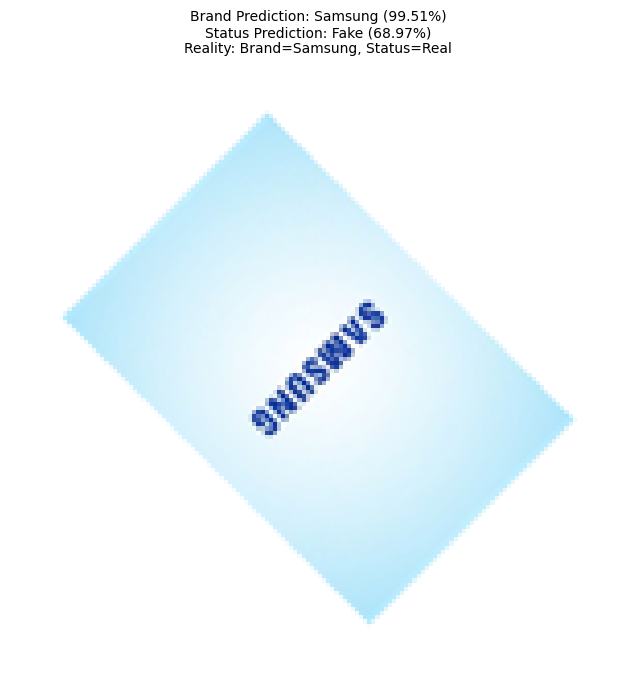


--- TESTING IMAGE: adidas_test.png (ROTAIION 0°) ---
 OOD CLASSIFICATION: OOD - Not part of the dataset (Maximum Confidence: 48.40%)


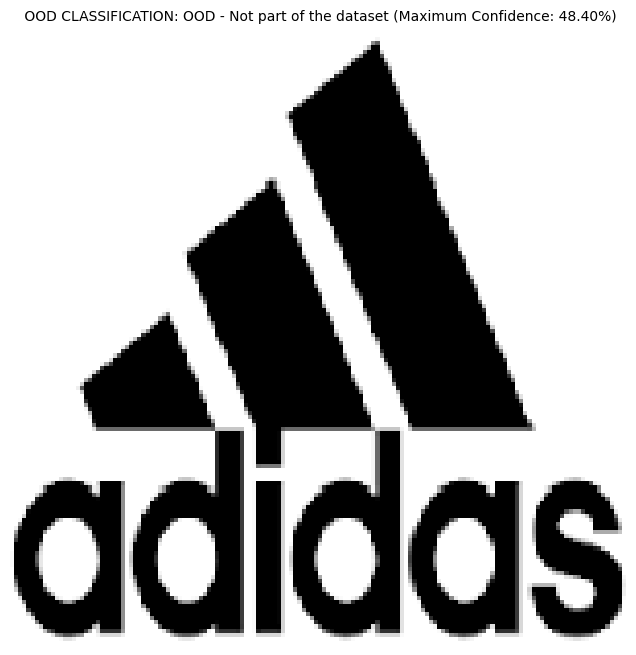

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- 1. SINGLE IMAGE PREPROCESSING FUNCTION (WITH ROTATION SUPPORT) ---
def preprocess_single_image(img_path, target_size, rotation_angle=0):
    if not os.path.exists(img_path): return None
    try:
        img = load_img(img_path, color_mode='rgb')
        img = img.resize(target_size)
        if rotation_angle != 0:
            img = img.rotate(rotation_angle, expand=False, fillcolor=(255, 255, 255))
        img_array = img_to_array(img) / 255.0
        return np.expand_dims(img_array, axis=0)
    except Exception: return None


# --- 2. FINAL PREDICTION FUNCTION (WITH OOD AND ROTATION LOGIC) ---
OOD_THRESHOLD = 0.90 # Probability threshold for image rejection (Out-of-Distribution)

def predict_logo(img_path, model, brand_names=BRAND_NAMES, rotation_angle=0, status_names=STATUS_NAMES):
    X = preprocess_single_image(img_path, IMG_SIZE, rotation_angle)
    if X is None: return {'Error': 'Unable to load or preprocess image.'}

    predictions = model.predict(X, verbose=0)
    pred_brand_vector = predictions[0][0]

    brand_idx = np.argmax(pred_brand_vector)
    brand_confidence = pred_brand_vector[brand_idx]

    # LOGIC OOD (If confidence is lower than threshold, consider it OOD)
    if brand_confidence < OOD_THRESHOLD:
        return {'Status': 'OOD - Not part of the dataset', 'Brand_Accuracy': f"{brand_confidence * 100:.2f}%", 'Rotation': rotation_angle}

    # If not OOD, proceed to classify Status
    pred_status_vector = predictions[1][0]
    status_idx = np.argmax(pred_status_vector)

    return {'Brand': brand_names[brand_idx],
            'Logo_Status': status_names[status_idx],
            'Brand_Accuracy': f"{brand_confidence * 100:.2f}%",
            'Status_Accuracy': f"{pred_status_vector[status_idx] * 100:.2f}%", 'Rotation': rotation_angle}


# --- 3. RUN SAMPLE PREDICTION (CHANGE PATH HERE) ---

# ---  FINAL TEST FUNCTION (PREDICTION AND DISPLAY) ---
def run_and_display_test(path_to_image, angle):
    print(f"\n--- TESTING IMAGE: {os.path.basename(path_to_image)} (ROTAIION {angle}°) ---")

    # Get the actual label
    actual_sample_df = master_df[master_df['image_path'] == path_to_image]
    if not actual_sample_df.empty:
        actual_brand = actual_sample_df.iloc[0]['Brand']
        actual_status = actual_sample_df.iloc[0]['Status_Label']
    else:
        actual_brand = 'OOD/UNKNOWN'
        actual_status = 'OOD/UNKNOWN'

    # Run predictions
    result = predict_logo(path_to_image, model, rotation_angle=angle)

    if 'Error' in result:
        print(f" SYSTEM ERROR: {result['Error']}")
        return

    # Processing prediction results
    if 'OOD' in result.get('Status', ''):
        full_title = (f" OOD CLASSIFICATION: {result['Status']} "
                      f"(Maximum Confidence: {result['Brand_Accuracy']})")
        print(full_title)
    else:
        full_title = (
            f"Brand Prediction: {result['Brand']} ({result['Brand_Accuracy']})\n"
            f"Status Prediction: {result['Logo_Status']} ({result['Status_Accuracy']})\n"
            f"Reality: Brand={actual_brand}, Status={actual_status}"
        )
        print(full_title)

    # Show image (only runs if original image exists)
    if os.path.exists(path_to_image):
        try:
            img = Image.open(path_to_image).resize(IMG_SIZE).rotate(angle, expand=False)
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.title(full_title, fontsize=10)
            plt.show()
        except Exception as e:
            print(f" DISPLAY ERROR: Cannot display image after processing: {e}")
    else:
        print(f" ERROR: Original file at path not found: {path_to_image}")


# TEST 1: Image in Dataset (Samsung)
test_path_1 = '/content/drive/MyDrive/[DS-B3] intro to DL/Dataset/Processed_Img/Samsung/Real/SR_001725.png'
run_and_display_test(test_path_1, angle=180)


# TEST 2: IMAGE OOD (Assumption: Not in dataset)
test_path_2 = '/content/drive/MyDrive/adidas_test.png'
run_and_display_test(test_path_2, angle=0)


